# Train/test/eval split for HBIM Library data.

This notebook outlines a method to split the library data in such a way that minimises the chances of the network learning "unhelpful" features while training upon it.

The approach does the following, relying on the fact that in the library file each mesh sub-category is non-overlapping:
1. each category's mesh file, containing all sub-meshes for that category, is chunked into cells of a specified width on the x-y plane
2. each of these is randomly assigned per-category on a weighted basis to three samples, for train, test and eval, at a 65%, 20%, and 15% weight respectively.
3. each is transformed such that roofs and ceilings are elevated (or else they will be indistinguishable from the floors, walkways, and grass paths - we want the network to take *something* away from the elevation information or else including these categories is borderline pointless).
4. the cells are then shuffled within each split
5. a seed cell is chosen, and we build up cells randomly in a spiral from the seed cell, translating subsequent cells in x and y as we go
6. the combined meshes can then be exported and saved, ready to be plugged into the pipeline

The library files still suffer from synthetic issues, most notably that the network cannot learn from typical adjacencies of each type of structure in the data, but this approach helps mitigate the following concerns that would otherwise happen in a more crude splitting of the data:
- the network may learn to rely on absolute x/y information, or relative x/y information between different elements if the network's radius of point localisation is high enough
- the network may come to believe that elements in the training have a higher adjacency than is the case in real data samples.

# NOTE FOR THE RAW .bin FILE!

The raw .bin file has the wrong name for the `13_OTHER` category, instead being called `13_MESH`. You can manually change this in Cloudcompare before running anything on the library .bin file.

In [1]:
from pointcept.supplemental.preprocessing import ParametrixPreprocessor
import subprocess
import shutil
import logging
import sys
import random
import re
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from pointcept.supplemental.utils import get_category_list
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# This is a data handling class to convert the raw .bin files as necessary to .ply, apply 
# any necessary transformations, and persist them to a predictable location.
# It can then load these on subsequent runs.
p = ParametrixPreprocessor("library")
p.ensure_meshes(bin_file="/home/sogilvy/library.bin")
p.meshes

06:37:13 - INFO - Input .bin specified: /home/sogilvy/library.bin
06:37:13 - INFO - Label library already has extracted meshes.


{'1_WALL': TriangleMesh with 5520 points and 2760 triangles.,
 '2_FLOOR': TriangleMesh with 2400 points and 1200 triangles.,
 '3_ROOF': TriangleMesh with 1680 points and 840 triangles.,
 '4_CEILING': TriangleMesh with 3840 points and 1920 triangles.,
 '5_FOOTPATH': TriangleMesh with 2400 points and 1200 triangles.,
 '6_GRASS': TriangleMesh with 432 points and 216 triangles.,
 '7_COLUMN': TriangleMesh with 1293085 points and 1322308 triangles.,
 '8_DOOR': TriangleMesh with 1814196 points and 1726857 triangles.,
 '9_WINDOW': TriangleMesh with 58283 points and 39485 triangles.,
 '10_STAIR': TriangleMesh with 258034 points and 232800 triangles.,
 '11_RAILING': TriangleMesh with 401512 points and 346260 triangles.,
 '12_RWP': TriangleMesh with 490764 points and 522314 triangles.,
 '13_OTHER': TriangleMesh with 1037417 points and 812920 triangles.}

In [3]:
import open3d as o3d
import numpy as np

def split_mesh_into_cells(mesh, cell_width):
    """
    Splits a mesh into smaller cells based on the specified cell width.

    Args:
        mesh (open3d.geometry.TriangleMesh): The mesh to be split.
        cell_width (float): The width of each cell.

    Returns:
        list: A list of TriangleMesh objects representing the cells.
    """
    cells = []
    aabb = mesh.get_axis_aligned_bounding_box()
    min_bound = aabb.get_min_bound()
    max_bound = aabb.get_max_bound()

    # Determine the number of cells in each dimension
    num_cells_x = int(np.ceil((max_bound[0] - min_bound[0]) / cell_width))
    num_cells_y = int(np.ceil((max_bound[1] - min_bound[1]) / cell_width))

    # Generate bounding boxes for each cell
    for i in range(num_cells_x):
        for j in range(num_cells_y):
            cell_min = np.array([min_bound[0] + i * cell_width, min_bound[1] + j * cell_width, min_bound[2]])
            cell_max = np.array([min_bound[0] + (i + 1) * cell_width, min_bound[1] + (j + 1) * cell_width, max_bound[2]])
            cell_aabb = o3d.geometry.AxisAlignedBoundingBox(min_bound=cell_min, max_bound=cell_max)
            cell_mesh = mesh.crop(cell_aabb)
            if not cell_mesh.is_empty():
                cells.append(cell_mesh)

    return cells

def divide_all_categories_into_cells(meshes_dict, cell_width):
    """
    Divides each category's mesh into grid cells.

    Args:
        meshes_dict (dict): Dictionary of category meshes.
        cell_width (float): The desired width for each cell.

    Returns:
        dict: A dictionary with each category mapping to a list of its cell meshes.
    """
    category_cells = {}
    for category, mesh in meshes_dict.items():
        category_cells[category] = split_mesh_into_cells(mesh, cell_width)
    return category_cells

def recenter_cell(mesh, category):
    """
    Recenter the mesh in x and y dimensions to the origin. Set the minimum z-coordinate to zero for all
    categories except '3_ROOF' and '4_CEILING', which receive a specific Gaussian z-offset.

    Args:
        mesh (open3d.geometry.TriangleMesh): Mesh to be recentered.
        category (str): The category of the mesh to determine z offset behavior.

    Returns:
        open3d.geometry.TriangleMesh: Recentered mesh with appropriate z offset.
    """
    aabb = mesh.get_axis_aligned_bounding_box()
    center = aabb.get_center()
    min_z = aabb.get_min_bound()[2]

    # Base translation to zero the mesh in z and center x, y
    base_translation = np.array([-center[0], -center[1], -min_z])
    mesh.translate(base_translation, relative=True)

    # Conditional offsets for '3_ROOF' and '4_CEILING'
    if category == '3_ROOF':
        additional_offset = np.random.normal(loc=6, scale=1)  # Gaussian centered at 20 with std deviation of 4
        mesh.translate([0, 0, additional_offset], relative=True)
    elif category == '4_CEILING':
        additional_offset = np.random.normal(loc=4, scale=1)  # Gaussian centered at 15 with std deviation of 4
        mesh.translate([0, 0, additional_offset], relative=True)

    return mesh

def transform_cells(cells_dict):
    """
    Transforms all cells in the dictionary by recentering them. The recentering includes 
    specific z-coordinate adjustments for categories '3_ROOF' and '4_CEILING'.

    Args:
        cells_dict (dict): Dictionary of categories, each with a list of TriangleMesh objects.

    Returns:
        dict: Dictionary with transformed cells for each category.
    """
    transformed_cells = {}
    for category, cells in cells_dict.items():
        transformed_cells[category] = [recenter_cell(cell, category) for cell in cells]
    return transformed_cells

def split_category_cells(cells, weights=(0.7, 0.2, 0.1), seed=None):
    """
    Splits a list of cells into train, test, and eval based on specified weights.

    Args:
        cells (list): List of TriangleMesh objects representing the cells.
        weights (tuple): Tuple of three elements representing the proportion for train, test, and eval.
        seed (int): Random seed for shuffling.

    Returns:
        dict: Dictionary containing lists of cells for 'train', 'test', 'eval'.
    """
    if seed is not None:
        random.seed(seed)
    random.shuffle(cells)

    total = len(cells)
    num_train = int(total * weights[0])
    num_test = int(total * weights[1])

    train_cells = cells[:num_train]
    test_cells = cells[num_train:num_train + num_test]
    eval_cells = cells[num_train + num_test:]

    return {'train': train_cells, 'test': test_cells, 'eval': eval_cells}

def split_all_categories(cells_dict, weights=(0.65, 0.2, 0.15), seed=None):
    """
    Splits cells from all categories into train, test, and eval splits based on weights.

    Args:
        cells_dict (dict): Dictionary of cells by category.
        weights (tuple): Weights for splitting into train, test, and eval.
        seed (int): Seed for random shuffling.

    Returns:
        dict: Dictionary with keys 'train', 'test', 'eval' containing lists of cells from all categories.
    """
    splits = {'train': [], 'test': [], 'eval': []}
    for category, cells in cells_dict.items():
        category_splits = split_category_cells(cells, weights, seed)
        splits['train'].extend(category_splits['train'])
        splits['test'].extend(category_splits['test'])
        splits['eval'].extend(category_splits['eval'])

    return splits

def generate_spiral_positions(n):
    """
    Generate coordinates in a spiral order.

    Args:
        n (int): Number of positions to generate.

    Returns:
        list of tuples: List of (x, y) coordinates.
    """
    x, y = 0, 0
    dx, dy = 0, -1
    positions = []
    for _ in range(n):
        if (-n/2 < x <= n/2) and (-n/2 < y <= n/2):
            positions.append((x, y))
        if x == y or (x < 0 and x == -y) or (x > 0 and x == 1-y):
            dx, dy = -dy, dx
        x, y = x + dx, y + dy
    return positions

def recenter_and_transform_cells(cells, cell_width, seed=None):
    """
    Recenter each cell to origin, then apply a transformation to arrange them in a spiral pattern.

    Args:
        cells (list): List of TriangleMesh objects.
        cell_width (float): The width of each cell.
        seed (int): Seed for random shuffling.

    Returns:
        open3d.geometry.TriangleMesh: The recombined mesh.
    """
    if seed is not None:
        random.seed(seed)
    random.shuffle(cells)
    
    positions = generate_spiral_positions(len(cells))
    
    combined_mesh = o3d.geometry.TriangleMesh()
    for cell, (dx, dy) in zip(cells, positions):
        # Translate cells to new positions
        translation = np.array([dx * cell_width, dy * cell_width, 0])
        cell.translate(translation, relative=True)
        combined_mesh += cell

    return combined_mesh

def process_splits(splits, cell_width, seed=None):
    """
    Process all splits (train, test, eval), transforming cells and combining them into single meshes.

    Args:
        splits (dict): Dictionary containing lists of cells for 'train', 'test', 'eval'.
        cell_width (float): The width of each cell.
        seed (int): Seed for random shuffling and transformations.

    Returns:
        dict: Dictionary with combined meshes for 'train', 'test', 'eval'.
    """
    combined_meshes = {}
    for split_name, cells in splits.items():
        if cells:  # Ensure there are cells to process
            combined_meshes[split_name] = recenter_and_transform_cells(cells, cell_width, seed)
        else:
            combined_meshes[split_name] = o3d.geometry.TriangleMesh()  # Empty mesh if no cells

    return combined_meshes

def plot_mesh_inline(mesh):
    """
    Visualize an Open3D mesh inline in a Jupyter Notebook using Matplotlib.

    Args:
        mesh (open3d.geometry.TriangleMesh): The mesh to visualize.
    """
    # Create a visualizer
    vis = o3d.visualization.Visualizer()
    vis.create_window(visible=False)  # Create a non-visible window
    vis.add_geometry(mesh)

    # Set up the view control and update the camera parameters
    ctr = vis.get_view_control()
    cam_params = ctr.convert_to_pinhole_camera_parameters()
    
    # Camera setup
    cam_eye = np.array([0, -10, 10])  # Position
    cam_lookat = np.array([0, 0, 0])  # Look at
    cam_up = np.array([0, 0, 1])      # Up vector

    cam_params.extrinsic = np.linalg.inv(np.array([
        [1, 0, 0, -cam_eye[0]],
        [0, 1, 0, -cam_eye[1]],
        [0, 0, 1, -cam_eye[2]],
        [0, 0, 0, 1]
    ]))
    cam_params.intrinsic.set_intrinsics(800, 600, 1000, 1000, 400, 300)  # Adjust focal length and principal point
    ctr.convert_from_pinhole_camera_parameters(cam_params)
    ctr.set_lookat(cam_lookat)
    ctr.set_front(cam_eye - cam_lookat)
    ctr.set_up(cam_up)
    ctr.set_zoom(0.35)

    # Update the renderer
    vis.update_geometry(mesh)
    vis.poll_events()
    vis.update_renderer()

    # Capture the image
    image = vis.capture_screen_float_buffer(do_render=True)
    plt.figure(figsize=(9, 5))  # Small figure size
    plt.imshow(np.asarray(image))
    plt.axis('off')
    plt.show()

    vis.destroy_window()

In [4]:
# This part splits the meshes into chunks and assigns them to train/test/eval splits.
cell_width = 2.5
category_cells = divide_all_categories_into_cells(p.meshes, cell_width)
transformed_category_cells = transform_cells(category_cells)
splits = split_all_categories(transformed_category_cells)

# This part recombines them, one per split.
random_seed = 9039501
processed_meshes = process_splits(splits, cell_width, seed=random_seed)

[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.


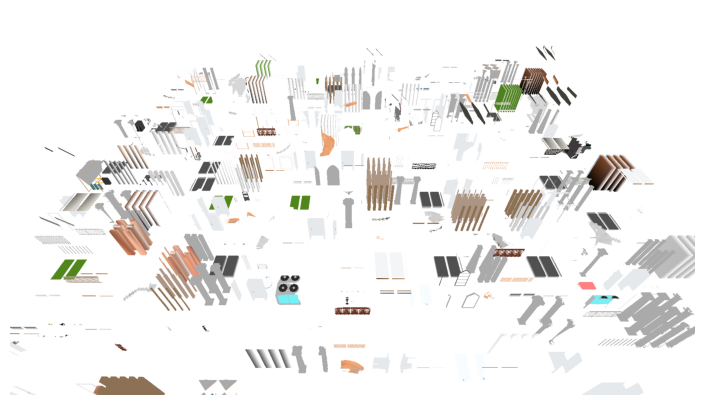

In [5]:
plot_mesh_inline(processed_meshes['train'])

[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.


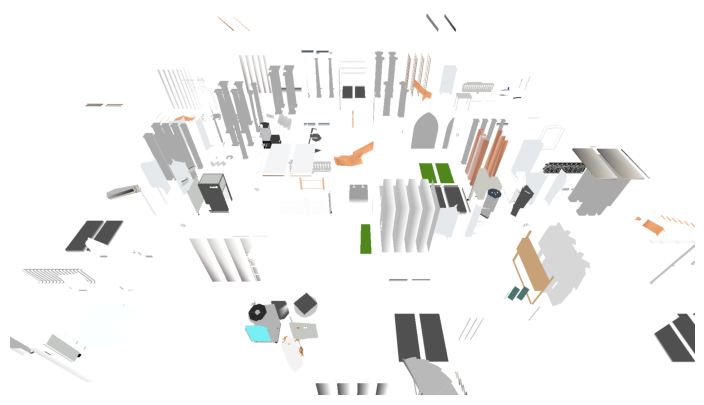

In [6]:
plot_mesh_inline(processed_meshes['test'])

[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.


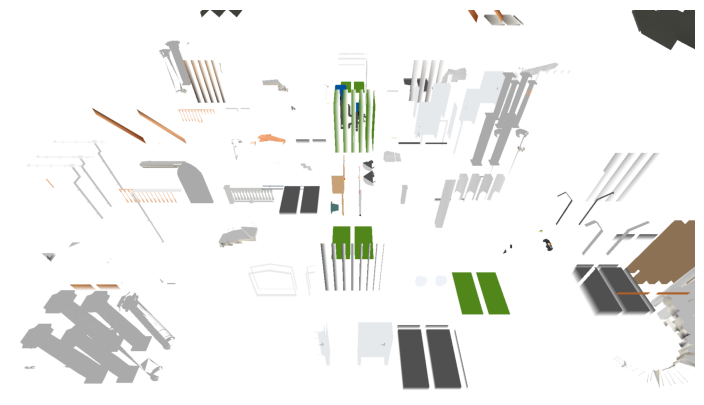

In [7]:
plot_mesh_inline(processed_meshes['eval'])